In [1]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Validation Sets and Test Sets

The previous Colab exercises evaluated the trained model against the training set, which does not provide a strong signal about the quality of your model. In this Colab, you'll experiment with validation sets and test sets.






## Learning objectives

After doing this Colab, you'll know how to do the following:

  * Split a [training set](https://developers.google.com/machine-learning/glossary/#training_set) into a smaller training set and a [validation set](https://developers.google.com/machine-learning/glossary/#validation_set).
  * Analyze deltas between training set and validation set results.
  * Test the trained model with a [test set](https://developers.google.com/machine-learning/glossary/#test_set) to determine whether your trained model is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting).
  * Detect and fix a common training problem.

## The dataset

As in the previous exercise, this exercise uses the [California Housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) to predict the `median_house_value` at the city block level.  Like many "famous" datasets, the California Housing Dataset actually consists of two separate datasets, each living in separate .csv files:

* The training set is in `california_housing_train.csv`.
* The test set is in `california_housing_test.csv`.

You'll create the validation set by dividing the downloaded training set into two parts:

* a smaller training set  
* a validation set

## Import relevant modules

As before, this first code cell imports the necessary modules and sets a few display options.

In [2]:
#@title Import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set.
* `test_df`, which contains the test set.



In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Scale the label values

The following code cell scales the `median_house_value`. 
See the previous Colab exercise for details.

In [4]:
scale_factor = 1000.0

# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

## Load the functions that build and train a model

The following code cell defines two functions:

  * `build_model`, which defines the model's topography.
  * `train_model`, which will ultimately train the model, outputting not only the loss value for the training set but also the loss value for the validation set. 

Since you don't need to understand model building code right now, we've hidden this code cell. As always, you must run hidden code cells.

In [5]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model               


def train_model(model, df, feature, label, my_epochs, 
                my_batch_size=None, my_validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=my_batch_size,
                      epochs=my_epochs,
                      validation_split=my_validation_split)

  # Gather the model's trained weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
  epochs = history.epoch
  
  # Isolate the root mean squared error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


## Define plotting functions

The `plot_the_loss_curve` function plots loss vs. epochs for both the training set and the validation set.

In [6]:
#@title Define the plotting function

def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


## Task 1: Experiment with the validation split

In the following code cell, you'll see a variable named `validation_split`, which we've initialized at 0.2.  The `validation_split` variable specifies the proportion of the original training set that will serve as the validation set. The original training set contains 17,000 examples. Therefore, a `validation_split` of 0.2 means that:

* 17,000 * 0.2 ~= 3,400 examples will become the validation set.
* 17,000 * 0.8 ~= 13,600 examples will become the new training set.

The following code builds a model, trains it on the training set, and evaluates the built model on both:

* The training set.
* And the validation set.

If the data in the training set is similar to the data in the validation set, then the two loss curves and the final loss values should be almost identical. However, the loss curves and final loss values are **not** almost identical. Hmm, that's odd.  

Experiment with two or three different values of `validation_split`.  Do different values of `validation_split` fix the problem? 


Epoch 1/30
102/102 [==============================] - 1s 4ms/step - loss: 51621.4030 - root_mean_squared_error: 227.1651 - val_loss: 38913.9922 - val_root_mean_squared_error: 197.2663
Epoch 2/30
102/102 [==============================] - 0s 4ms/step - loss: 35896.5081 - root_mean_squared_error: 189.4065 - val_loss: 25757.9238 - val_root_mean_squared_error: 160.4928
Epoch 3/30
102/102 [==============================] - 0s 4ms/step - loss: 23749.8292 - root_mean_squared_error: 154.0211 - val_loss: 16152.1934 - val_root_mean_squared_error: 127.0913
Epoch 4/30
102/102 [==============================] - 0s 3ms/step - loss: 14894.1726 - root_mean_squared_error: 121.9636 - val_loss: 9996.5566 - val_root_mean_squared_error: 99.9828
Epoch 5/30
102/102 [==============================] - 0s 3ms/step - loss: 9451.0878 - root_mean_squared_error: 97.1588 - val_loss: 7165.6675 - val_root_mean_squared_error: 84.6503
Epoch 6/30
102/102 [==============================] - 0s 4ms/step - loss: 7341.6382 - 

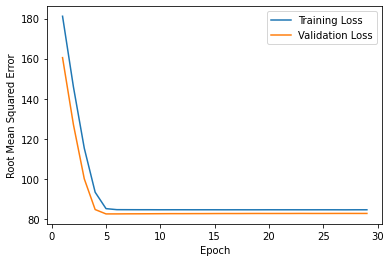

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 30
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.4

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on the neighborhood's median income.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions to build and train the model.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

## Task 2: Determine **why** the loss curves differ

No matter how you split the training set and the validation set, the loss curves differ significantly. Evidently, the data in the training set isn't similar enough to the data in the validation set. Counterintuitive? Yes, but this problem is actually pretty common in machine learning. 

Your task is to determine **why** the loss curves aren't highly similar. As with most issues in machine learning, the problem is rooted in the data itself. To solve this mystery of why the training set and validation set aren't almost identical, write a line or two of [pandas code](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=validation-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en) in the following code cell.  Here are a couple of hints:

  * The previous code cell split the original training set into:
    * a reduced training set (the original training set - the validation set)
    * the validation set 
  * By default, the pandas [`head`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method outputs the *first* 5 rows of the DataFrame. To see more of the training set, specify the `n` argument to `head` and assign a large positive integer to `n`.

In [14]:
pd.set_option('max_rows', 100)
train_df.head(n=100)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
5,-114.6,33.6,29.0,1387.0,236.0,671.0,239.0,3.3,74.0
6,-114.6,33.6,25.0,2907.0,680.0,1841.0,633.0,2.7,82.4
7,-114.6,34.8,41.0,812.0,168.0,375.0,158.0,1.7,48.5
8,-114.6,33.6,34.0,4789.0,1175.0,3134.0,1056.0,2.2,58.4
9,-114.6,34.8,46.0,1497.0,309.0,787.0,271.0,2.2,48.1


In [ ]:
#@title Double-click for a possible solution to Task 2.

# Examine examples 0 through 4 and examples 25 through 29
# of the training set
train_df.head(n=1000)

# The original training set is sorted by longitude. 
# Apparently, longitude influences the relationship of
# total_rooms to median_house_value.

## Task 3. Fix the problem

To fix the problem, shuffle the examples in the training set before splitting the examples into a training set and validation set. To do so, take the following steps:

1. Shuffle the data in the training set by adding the following line anywhere before you call `train_model` (in the code cell associated with Task 1):

```
  shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
```                                    

2. Pass `shuffled_train_df` (instead of `train_df`) as the second argument to `train_model` (in the code call associated with Task 1) so that the call becomes as follows:

```
  epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                      my_label, epochs, batch_size, 
                                      validation_split)
```

In [15]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))

Epoch 1/30
128/128 [==============================] - 1s 4ms/step - loss: 50326.6540 - root_mean_squared_error: 224.2456 - val_loss: 34807.5820 - val_root_mean_squared_error: 186.5679
Epoch 2/30
128/128 [==============================] - 1s 4ms/step - loss: 31127.1087 - root_mean_squared_error: 176.2848 - val_loss: 20262.2793 - val_root_mean_squared_error: 142.3456
Epoch 3/30
128/128 [==============================] - 1s 4ms/step - loss: 17446.1738 - root_mean_squared_error: 132.0146 - val_loss: 11168.6895 - val_root_mean_squared_error: 105.6820
Epoch 4/30
128/128 [==============================] - 0s 3ms/step - loss: 10070.9518 - root_mean_squared_error: 100.2619 - val_loss: 7317.9946 - val_root_mean_squared_error: 85.5453
Epoch 5/30
128/128 [==============================] - 0s 4ms/step - loss: 7183.9537 - root_mean_squared_error: 84.7470 - val_loss: 6992.9590 - val_root_mean_squared_error: 83.6239
Epoch 6/30
128/128 [==============================] - 1s 4ms/step - loss: 6898.5835 - 

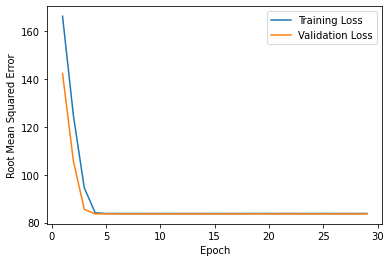

In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 30
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set. 
validation_split = 0.25

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on the neighborhood's median income.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions to build and train the model.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

Experiment with `validation_split` to answer the following questions:

* With the training set shuffled, is the final loss for the training set closer to the final loss for the validation set?  
* At what range of values of `validation_split` do the final loss values for the training set and validation set diverge meaningfully?  Why?

In [21]:
# Yes, after shuffling the original training set, 
# the final loss for the training set and the 
# validation set become much closer.

# If validation_split < 0.15,
# the final loss values for the training set and
# validation set diverge meaningfully.  Apparently,
# the validation set no longer contains enough examples. 

## Task 4: Use the Test Dataset to Evaluate Your Model's Performance

The test set usually acts as the ultimate judge of a model's quality. The test set can serve as an impartial judge because its examples haven't been used in training the model. Run the following code cell to evaluate the model with the test set:

In [23]:
x_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)

30/30 [==============================] - 0s 4ms/step - loss: 7011.6226 - root_mean_squared_error: 83.7354


Compare the root mean squared error of the model when evaluated on each of the three datasets:

* training set: look for `root_mean_squared_error` in the final training epoch.
* validation set: look for `val_root_mean_squared_error` in the final training epoch.
* test set: run the preceding code cell and examine the `root_mean_squared_error`.

Ideally, the root mean squared error of all three sets should be similar. Are they?

In [24]:
# In our experiments, yes, the rmse values 
# were similar enough. 